```
This notebook analyses gravity reduction 
Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: ca2502127969ef8eb828499ac582af6fc10a2747 on branch reduced_gravity


# Oslofjord: Spatially Changing Gravity

This notebook shows how the reduced gravity would change under the use of `g^*` instead of `g'`

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler gpu_ctx

Path to the test file

In [5]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

## Generating GPUOcean Simulation from Input

In [7]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

Check Mixed-Layer Depth

In [8]:
t=5*24 + 11 # INPUT

In [9]:
mld = NetCDFInitialization.MLD(source_url, 1024, min_mld=1.5, max_mld=40, x0=x0, x1=x1, y0=y0, y1=y1, t=t)

In [11]:
ml_integrator = NetCDFInitialization.MLD_integrator(source_url, mld, x0=x0, x1=x1, y0=y0, y1=y1)

In [13]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)
ml_pot_density = np.average(np.sum(ml_integrator * s_pot_densities, axis=0)/np.sum(ml_integrator, axis=0)) #NOTE: np.sum(integrator, axis=0)) = mld

inverse_integrator = np.ma.array(np.ones_like(ml_integrator), mask=ml_integrator.mask.copy()) - ml_integrator
deep_pot_density  = np.average(np.sum(inverse_integrator * s_pot_densities, axis=0)/np.sum(inverse_integrator, axis=0))

eps = (deep_pot_density - ml_pot_density)/deep_pot_density

g = eps * 9.81
g

0.021834041572662354

In [15]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][y0:y1,x0:x1], mask=1-nc["mask_rho"][y0:y1,x0:x1])

In [16]:
H_m = np.ma.array(nc["h"][y0:y1,x0:x1], mask=1-nc["mask_rho"][y0:y1,x0:x1])

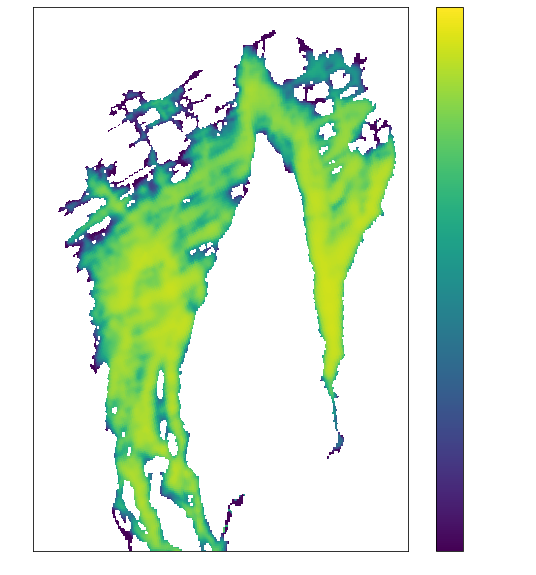

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(g * 1/(1+np.minimum(1.0,mld/H_m)),
            vmin = g/2, vmax = g)
cb = plt.colorbar()
cb.set_label(label="reduced gravity [$m/s^2$]", size=20)

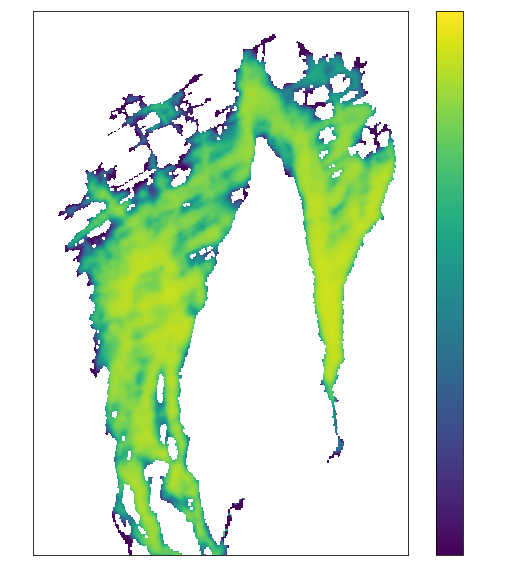

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(1/(1+np.minimum(1.0,mld/H_m)),
            vmin = 1/2, vmax = 1)
cb = plt.colorbar()
cb.set_label(label="reduction factor [0.5, 1]", size=20)